The goal of this notebook is to **explore the possibility of using Google's GTFS Data to find out how many trains are operating in the NYC Subway at any given time**. 

More info about [GTFS Data](https://gtfs.org) in general. There are two types: 
- schedule data 
- real time data [extra information about this](https://doodles.patrickweaver.net/working-with-nyc-mta-realtime-subway-data/slides/4/)

I don't notice any difference between the two. I'll just use schedule data

[MTA Developer Tools](https://new.mta.info/developers). The google data for the mta should be all that we need. There's weekday, saturday, and sunday service so only need to worry about those times. Additionally, there's data on the buses, LIRR and Metro North in there, too.
- [mta metrics dashboard](https://metrics.mta.info/?subway/customerjourneytimeperformance)

[time frequency](https://en.wikipedia.org/wiki/List_of_New_York_City_Subway_services#Train_frequency_charts) breakdown

[The project](https://tyleragreen.com/maps/new_york/) that inspired this one. [General Subway trivia](https://www.nycsubway.org/wiki/Main_Page)

Some notes about the results:
- the routes change by day of week (for example the M not running its whole route on the weekends)
- some routes include service changes (the 7 and 7 express both count as the 7)
- this also includes late nights where the routes can change dramatically (e.g.: the 5 train doesn't leave the BX at night)
- two routes don't run on the weekends: the B and W

# Imports

In [208]:
import pandas as pd
import numpy as np
import geopandas
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings(action='once')

## Functions 

In [341]:
def determine_train_time_intervals(arrival_time, day_of_week: str):
    arrival_time = arrival_time.time()
    train_time_interval = None
    if datetime.time(0, 0) <= arrival_time < datetime.time(6, 30):
        train_time_interval = 'Late Night'
    elif day_of_week in ['Saturday', 'Sunday']:
        train_time_interval = 'Weekend'
    elif datetime.time(6, 30) <= arrival_time < datetime.time(9, 30):
        train_time_interval = 'Rush Hour AM'
    elif datetime.time(9, 30) <= arrival_time < datetime.time(15, 30):
        train_time_interval = 'Midday'
    elif datetime.time(15, 30) <= arrival_time < datetime.time(20, 0):
        train_time_interval = 'Rush Hour PM'
    elif datetime.time(20, 0) <= arrival_time <= datetime.time(23, 59):
        train_time_interval = 'Evening'
    return train_time_interval

def scale_time_intervals_to_hour(df_grouped_at_interval_level: pd.DataFrame):
    for idx, row in df_grouped_at_interval_level.iterrows():
        if row['train_time_interval'] == 'Late Night':
            new_tph = (row['trains_per_hour'] / 3) / 6.5 # multiply by days ratio and hours ratio 
            df_grouped_at_interval_level.at[idx, 'trains_per_hour'] = new_tph
        elif row['train_time_interval'] == 'Weekend':
            new_tph = (row['trains_per_hour'] / 2) / 17.5 # multiply by days ratio and hours ratio 
            df_grouped_at_interval_level.at[idx, 'trains_per_hour'] = new_tph
        elif row['train_time_interval'] == 'Rush Hour AM':
            new_tph = row['trains_per_hour'] / 3 # multiply by days ratio and hours ratio 
            df_grouped_at_interval_level.at[idx, 'trains_per_hour'] = new_tph
        elif row['train_time_interval'] == 'Midday':
            new_tph = row['trains_per_hour'] / 6 # multiply by days ratio and hours ratio 
            df_grouped_at_interval_level.at[idx, 'trains_per_hour'] = new_tph
        elif row['train_time_interval'] == 'Rush Hour PM':
            new_tph = row['trains_per_hour'] / 4.5 # multiply by days ratio and hours ratio 
            df_grouped_at_interval_level.at[idx, 'trains_per_hour'] = new_tph
        elif row['train_time_interval'] == 'Evening':
            new_tph = row['trains_per_hour'] / 4 # multiply by days ratio and hours ratio 
            df_grouped_at_interval_level.at[idx, 'trains_per_hour'] = new_tph
    return df_grouped_at_interval_level

# Real Time Data

In [3]:
trips_supplemented_df = pd.read_csv("google_transit_supplemented/trips.txt")
trips_supplemented_df.head()

In [339]:
# trips_supplemented_df.groupby('service_id').size()

In [84]:
trips_supplemented_df.route_id.nunique()

29

In [85]:
trips_supplemented_df.route_id.unique()

array(['1', '2', '3', '4', '5', '6', '6X', '7', '7X', 'GS', 'A', 'B', 'C',
       'D', 'E', 'F', 'FX', 'FS', 'G', 'H', 'J', 'Z', 'L', 'M', 'N', 'W',
       'Q', 'R', 'SI'], dtype=object)

In [176]:
trips_supplemented_df.trip_id.nunique()

60068

## Schedule Data

In [5]:
# holdays and other days when the data would be different than expected
calendar_dates_df = pd.read_csv("google_transit/calendar_dates.txt") 
calendar_df = pd.read_csv("google_transit/calendar.txt")
routes_df = pd.read_csv("google_transit/routes.txt")
stop_times_df = pd.read_csv("google_transit/stop_times.txt")
stops_df = pd.read_csv("google_transit/stops.txt")
transfers_df = pd.read_csv("google_transit/transfers.txt")
trips_df = pd.read_csv("google_transit/trips.txt")
# not useful data 
# agency_df = pd.read_csv("google_transit/agency.txt")
shapes_df = pd.read_csv("google_transit/shapes.txt")

In [6]:
all_dfs_list = [calendar_dates_df, calendar_df, routes_df, shapes_df
               , stop_times_df, stops_df, transfers_df, trips_df]

# Adjustments to the GTFS Dfs

## Date Format

In [8]:
# calendar_dates_df['date'].astype('datetime')
calendar_dates_df['date'] = pd.to_datetime(calendar_dates_df['date'], format="%Y%m%d")

In [9]:
calendar_df['start_date'] = pd.to_datetime(calendar_df['start_date'], format="%Y%m%d")
calendar_df['end_date'] = pd.to_datetime(calendar_df['end_date'], format="%Y%m%d")

In [10]:
# shapes_df[shapes_df['shape_id']=='1..N03R']

In [11]:
stop_times_df['arrival_time'] = pd.to_datetime(stop_times_df['arrival_time'], format="%H:%M:%S"
                                                  , errors='coerce')
stop_times_df['departure_time'] = pd.to_datetime(stop_times_df['departure_time'], format="%H:%M:%S"
                                                    , errors='coerce')

## Removing Some of the data

In [12]:
# removing lat lon data
# shapes_df.drop(columns=['shape_pt_lat', 'shape_pt_lon'], inplace=True)
stops_df.drop(columns=['stop_lat', 'stop_lon'], inplace=True)
stop_times_df = stop_times_df[~stop_times_df['arrival_time'].isnull()]

## Exploring the data

In [13]:
# calendar_dates_df.head()

In [14]:
# calendar_df.head()

In [367]:
# routes_df[routes_df['route_short_name']=='W']['route_desc'].values

In [16]:
# all of the trips
stop_times_df.head(2)

,trip_id,stop_id,arrival_time,departure_time,stop_sequence
0,AFA23GEN-1038-Sunday-00_000600_1..S03R,101S,1900-01-01 00:06:00,1900-01-01 00:06:00,1
1,AFA23GEN-1038-Sunday-00_000600_1..S03R,103S,1900-01-01 00:07:30,1900-01-01 00:07:30,2


In [17]:
print(stops_df.stop_name.nunique())
stops_df.head()

380


,stop_id,stop_name,location_type,parent_station
0,101,Van Cortlandt Park-242 St,1.0,NaN
1,101N,Van Cortlandt Park-242 St,NaN,101
2,101S,Van Cortlandt Park-242 St,NaN,101
3,103,238 St,1.0,NaN
4,103N,238 St,NaN,103


In [18]:
transfers_df.head()

,from_stop_id,to_stop_id,transfer_type,min_transfer_time
0,101,101,2,180
1,103,103,2,180
2,104,104,2,180
3,106,106,2,180
4,107,107,2,180


In [20]:
# route_id is the short_route_name (Z train is lumped together with the J train for trips ids)
trips_df.head(2)

,route_id,trip_id,service_id,trip_headsign,direction_id,shape_id
0,1,AFA23GEN-1038-Sunday-00_000600_1..S03R,Sunday,South Ferry,1,1..S03R
1,1,AFA23GEN-1038-Sunday-00_002600_1..S03R,Sunday,South Ferry,1,1..S03R


In [21]:
trips_df.shape

(20365, 6)

In [72]:
# get the memory usage of each table in KB
# for df in all_dfs_list:
#     print(f"{df.memory_usage().sum()/1000}")
# shapes_df and stop_times are the larger tables
# I halved the memory usage by removing the lat and lon data in 2 tables

## Finding Beginning of Each Route
Using Stop Times df

In [361]:
first_stop_in_trip['route_id'].unique()

array(['1', '2', '3', '4', '5', '6', 'GS', 'A', 'B', 'C', 'D', 'FS', 'G',
       'H', 'J', 'L', 'M', 'N', 'Q', 'R', '7', 'E', 'F', 'SI'],
      dtype=object)

In [267]:
first_stop_in_trip = stop_times_df[stop_times_df['stop_sequence']==1]

first_stop_in_trip['departure_hour'] = first_stop_in_trip['departure_time'].dt.hour
first_stop_in_trip['route_id'] = [x.split("_")[-1].split('.')[0] 
                                        for x in first_stop_in_trip['trip_id']]
first_stop_in_trip['shape_id'] = [x.split("_")[-1] for x in first_stop_in_trip['trip_id']]
first_stop_in_trip = first_stop_in_trip[~first_stop_in_trip.arrival_time.isnull()]

/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [268]:
day_of_week_list = []
for x in first_stop_in_trip['trip_id']:
    if 'Weekday' in x or 'L0S1' in x:
        day_of_week_list.append('Weekday')
    elif 'Saturday' in x or 'L0S2' in x:
        day_of_week_list.append('Saturday')
    elif 'Sunday' in x or 'L0S3' in x:
        day_of_week_list.append('Sunday')
first_stop_in_trip['day_of_week'] = day_of_week_list

In [269]:
# ~21K trips per day
# 870 made per hour
first_stop_in_trip_weekdays = first_stop_in_trip[first_stop_in_trip['day_of_week'].str.contains('Weekday')]
first_stop_in_trip_saturdays = first_stop_in_trip[first_stop_in_trip['day_of_week'].str.contains('Saturday')]
first_stop_in_trip_sundays = first_stop_in_trip[first_stop_in_trip['day_of_week'].str.contains('Sunday')]

In [386]:
# first_stop_in_trip[first_stop_in_trip['shape_id'].isnull()]
first_stop_in_trip.head(2)

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,departure_hour,route_id,shape_id,day_of_week,train_time_interval
0,AFA23GEN-1038-Sunday-00_000600_1..S03R,101S,1900-01-01 00:06:00,1900-01-01 00:06:00,1,0.0,1,1..S03R,Sunday,Late Night
38,AFA23GEN-1038-Sunday-00_002600_1..S03R,101S,1900-01-01 00:26:00,1900-01-01 00:26:00,1,0.0,1,1..S03R,Sunday,Late Night


In [408]:
# Making the data be "per direction" (closer to how an average person would think interpret this)
# the shuttles only have 1 "." -- very close to 50:50 (50.6 ~ 49.4)
directions = []
for x in first_stop_in_trip['shape_id']:
    direction = x.split(".", 1)[1]
    if "S" in direction:
        directions.append("S")
    else:
        directions.append("N")
first_stop_in_trip['direction'] = directions
first_stop_in_trip = first_stop_in_trip[first_stop_in_trip['direction'] == 'S']

### By Day

In [409]:
first_stop_in_trip_per_day = pd.DataFrame(first_stop_in_trip.groupby(
                                                ['route_id', 'day_of_week']
                                                ).size() / 24).reset_index()
first_stop_in_trip_per_day.columns = ['route_id', 'day_of_week', 'trains_per_hour']
first_stop_in_trip_per_day['headway_seconds'] = round(3600 / \
                                                            first_stop_in_trip_per_day['trains_per_hour'])
first_stop_in_trip_per_day['headway_minutes'] = round(60 / \
                                                            first_stop_in_trip_per_day['trains_per_hour'], 1)

### By Hour

In [411]:
# freq by hour for all routes and all days on schedule 
route_trip_freq_by_hour = first_stop_in_trip.groupby(['route_id', 'day_of_week', 'departure_hour']).sum()

In [412]:
route_trip_freq_by_hour.columns = ['trains_per_hour']
route_trip_freq_by_hour['headway_seconds'] = round(3600 / \
                                                            route_trip_freq_by_hour['trains_per_hour'])
route_trip_freq_by_hour['headway_minutes'] = round(60 / \
                                                            route_trip_freq_by_hour['trains_per_hour'], 1)

In [414]:
# route_trip_freq_by_hour.sort_values(by=['route_id', 'departure_hour'])[50:75]

### Overall

In [415]:
# avg daily freq all routes 
route_trip_freq_overall_by_hour = route_trip_freq_by_hour['trains_per_hour'].unstack(level=1)
route_trip_freq_overall_by_hour.fillna(value=0, inplace=True) # needed b/c there's no weekend B trains
route_trip_freq_overall_by_hour['Weekday_Adjusted'] = route_trip_freq_overall_by_hour['Weekday'] * 5
route_trip_freq_overall_by_hour['Hourly_tph'] = route_trip_freq_overall_by_hour['Weekday_Adjusted'] + \
                                                route_trip_freq_overall_by_hour['Saturday'] + \
                                                route_trip_freq_overall_by_hour['Sunday']

In [416]:
route_trip_freq_overall_by_day = route_trip_freq_overall_by_hour.groupby(['route_id']).sum() / 24
route_trip_freq_overall_by_day.columns = ['Saturday', 'Sunday', 'Weekday'
                                          , 'Weekday_Adjusted', 'Total_trains_per_day']
route_trip_freq_overall_by_day['Trains_per_Hour_Overall'] = round(route_trip_freq_overall_by_day \
                                                                  ['Total_trains_per_day'] / 7, 1)
# the wait time is half of the mean time between trains
route_trip_freq_overall_by_day['headway_minutes'] = round(60 / \
                                                            route_trip_freq_overall_by_day['Trains_per_Hour_Overall']
                                                                 , 1)

In [417]:
route_trip_freq_overall_by_day.sort_values(by='Trains_per_Hour_Overall')

,Saturday,Sunday,Weekday,Weekday_Adjusted,Total_trains_per_day,Trains_per_Hour_Overall,headway_minutes
route_id,,,,,,,
SI,2.000000,2.000000,3.250000,16.250000,20.250000,2.9,20.7
B,0.000000,0.000000,4.083333,20.416667,20.416667,2.9,20.7
H,3.458333,3.041667,3.500000,17.500000,24.000000,3.4,17.6
C,3.375000,3.125000,4.625000,23.125000,29.625000,4.2,14.3
FS,4.708333,4.125000,4.916667,24.583333,33.416667,4.8,12.5
M,5.708333,4.833333,5.250000,26.250000,36.791667,5.3,11.3
D,4.500000,4.500000,5.708333,28.541667,37.541667,5.4,11.1
J,5.416667,4.833333,5.750000,28.750000,39.000000,5.6,10.7
3,4.458333,4.250000,6.333333,31.666667,40.375000,5.8,10.3


### By Train Time Interval

In [418]:
train_time_interval_list = []
for idx, row in first_stop_in_trip.iterrows():
    train_time_interval = determine_train_time_intervals(row['arrival_time'], row['day_of_week'])
    train_time_interval_list.append(train_time_interval)
first_stop_in_trip['train_time_interval'] = train_time_interval_list

/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [419]:
first_stop_in_trip_per_interval = pd.DataFrame(first_stop_in_trip.groupby(
                                                ['route_id', 'train_time_interval']
                                                ).size()).reset_index()
first_stop_in_trip_per_interval.columns = ['route_id', 'train_time_interval', 'trains_per_hour']
first_stop_in_trip_per_interval = scale_time_intervals_to_hour(first_stop_in_trip_per_interval)
first_stop_in_trip_per_interval['headway_seconds'] = round(3600 / \
                                                            first_stop_in_trip_per_interval['trains_per_hour'])
first_stop_in_trip_per_interval['headway_minutes'] = round(60 / \
                                                            first_stop_in_trip_per_interval['trains_per_hour'], 1)

In [421]:
# first_stop_in_trip_per_interval[first_stop_in_trip_per_interval['train_time_interval'].isin(['Late Night'])]

### Other Testing

In [422]:
# route_trip_freq_by_hour['trains_per_hour'].unstack(level=0)

In [35]:
# I wasn't too far off when I said "the L on it's worse day is better than the G on it's best day"
# first_stop_in_trip_per_day[first_stop_in_trip_per_day['route_id'].isin(['L', 'G'])]
first_stop_in_trip_per_day[first_stop_in_trip_per_day['route_id'].isin(['L', '7', '6'])]

,route_id,day_of_week,trains_per_hour,mean_wait_time_seconds,mean_wait_time_minutes
15,6,Saturday,14.583333,247.0,4.1
16,6,Sunday,12.833333,281.0,4.7
17,6,Weekday,23.000000,157.0,2.6
18,7,Saturday,18.750000,192.0,3.2
19,7,Sunday,15.083333,239.0,4.0
20,7,Weekday,26.750000,135.0,2.2
52,L,Saturday,20.750000,173.0,2.9
53,L,Sunday,18.583333,194.0,3.2
54,L,Weekday,22.750000,158.0,2.6


What's the ratio between weekday service and sunday service? AKA, how much do the trains vary by day of week?

##### Viewing the Data Visually

In [426]:
# getting the order of best performers (on weekday performance)
sorted_routes = first_stop_in_trip_per_day[first_stop_in_trip_per_day
                                 ['day_of_week']=='Weekday'].sort_values(by='trains_per_hour')['route_id'].values

<AxesSubplot:xlabel='route_id', ylabel='headway_minutes'>

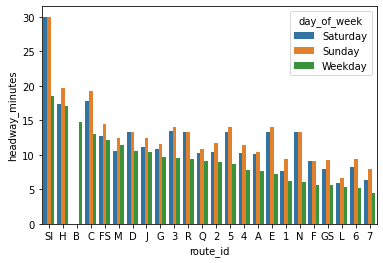

In [427]:
sns.barplot(data=first_stop_in_trip_per_day, x='route_id'
           , y='headway_minutes', hue='day_of_week', order=sorted_routes)

### Maniuplating stop_times using shape_id

In [428]:
# select the min and max stop number for each route 
# max stop sequence for each trip 
# stop_times_df['trip_id'].nunique()

In [429]:
# unique_trips_w_stop_seq = pd.DataFrame(stop_times_df.groupby('trip_id').max()['stop_sequence'].reset_index())
# unique_trips_w_stop_seq['route_id'] = [x.split("_")[-1].split('.')[0] for x in unique_trips_w_stop_seq['trip_id']]
# unique_trips_w_stop_seq['shape_id'] = [x.split("_")[-1] for x in unique_trips_w_stop_seq['trip_id']]
# unique_trips_w_stop_seq.head()

In [430]:
# route_trip_max_stop = unique_trips_w_stop_seq.groupby(['shape_id']).max().reset_index()

### Can I deconstruct the trip_id?

In [431]:
# route_trip_max_stop['trip_id'].str.count("_").unique()
# route_trip_max_stop['trip_id'].str.count("-").unique() # only SIR has 4 dashes

In [432]:
# all_first_values = [] # I think this has to do with the train set (A div or B div)
# all_second_values = [] # I think this has something to do with the (long) route id
# for trip in route_trip_max_stop['trip_id']:
#     values_list = trip.split("-")
#     if values_list[0] not in all_first_values:
#         all_first_values.append(values_list[0])
#     if values_list[1] not in all_second_values:
#         all_second_values.append(values_list[1])

# Saving the Transformed Data

In [436]:
first_stop_in_trip.to_csv("first_stop_in_trip.csv")
route_trip_freq_by_hour.to_csv("route_trip_freq_by_hour.csv")
first_stop_in_trip_per_day.to_csv("first_stop_in_trip_per_day.csv")
route_trip_freq_overall_by_day.to_csv("route_trip_freq_overall_by_day.csv")
first_stop_in_trip_per_interval.to_csv("first_stop_in_trip_per_interval.csv")